# Avaliação de Risco de Crédito


Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes.

Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância e pode causar um grande impacto no balanço da Instituição. Toda instituição guarda uma reserva para investir no empréstimo aos clientes, desde que esse investimento tenha um retorno maior do que se ela colocasse em algum outro tipo de investimento. A pergunta que os executivos fazem é: "Qual o default teto que a carteira oferece?" Se esse default for maior que o rendimento que as instituições perderiam se deixasse o dinheiro investido de modo seguro, o empréstimo não é feito e não há disposição do crédito para o cliente.

*Default* é o termo utilizado para indicado o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito). Normalmente, o principal motivo para o descumprimento das condições de pagamento é incapacidade financeira do cliente.

<p align=center>
  <img src="https://raw.githubusercontent.com/inaepmachado/Portfolio/master/imagens/cr.jpg" height="150px">
</p>
 
Grandes bancos e Fintechs têm apostado cada vez mais em modelos de *Machine Learning* para prevenir a inadimplência dos clientes, modelos são construídos e constantemente avaliados e recalibrados, a fim de sempre garantir o default abaixo do teto estabelecido, conforme explicado acima.


O conjunto de dados a ser utilizado neste Projeto de *Data Science* parte de uma competição realizada por uma startup a fim de revelar talentos e potenciais contratações pela Fintech.

## Contextualização do Problema

Neste problema, o objetivo foi prever qual a probabilidade de um cliente da Fintech não cumprir com suas obrigações financeiras e deixar de pagar a sua fatura do Cartão de Crédito.

Vale ressaltar que essa avaliação deve ser realizada no momento em que o cliente solicita o cartão, normalmente no primeiro contato com a instituição. Em algums casos, ocorre a oferta ativa do cartão por parte das instituições, mas com um risco mais ainda controlado, um teto de default mais ainda restrito e para um número bem menor de possíveis clientes.


> OBJETIVO: Criar um modelo que indique se um cliente irá virar inadimplente.

Espera-se que um modelo seja capaz de minimizar as perdas financeiras da Fintech, porém minimizando também os falsos positivos.

### Hipóteses Iniciais

## Importar os Dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](https://www.dropbox.com/s/ij4iw9lwpl561gf/acquisition_train.csv?dl=0). Consiste basicamente em um arquivo `csv` contendo 45.000 entradas e 43 colunas.

In [2]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [26]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# definir o estilo do seaborn para os plots
sns.set_style('dark')

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("https://www.dropbox.com/s/ij4iw9lwpl561gf/acquisition_train.csv?dl=1")

## Análise Exploratória de Dados

A primeira coisa que faremos após importar o *dataset* diretamente do dropbox será examinar as dimensões do *DataFrame* e as primeiras entradas. Isso possibilitará entender o formato de entrada e da estrutura geral dos dados.

In [ ]:
# dimensões do df
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		45000
Colunas:	43


Nosso banco de dados é composto por 45 mil registros e 43 colunas/variáveis. Isso é importante saber tanto para termos idéia do tamanho dos dados que iremos trabalhar como também controle de todas as transformações necessárias para o desenvolvimento do projeto: separar os dados entre treino e teste, controle do balanceamento dos dados etc.

Já as primeiras 5 entradas desse conjunto de dados permitem adquirirmos uma noção inicial sobre o tipo de formato, exemplos de entrada e formulação das hipóteses iniciais do processo investigativo.

In [ ]:
# ver as 5 primeiras entradas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN



Algumas conclusões iniciais que podem ser destacadas a respeito desse análise inicial:

* Existe uma coluna `id`, que representa um identificador único do cliente. Pela estrutura da informação, é um identificador anônimo, não contendo nenhuma informação relevante, podendo ser eliminada do banco de dados a ser trabalhado.
* A variável alvo para analisar o risco de *default* (inadimplência) está na coluna `target_default`. Ela está como string `true`ou `false`, havendo necessidade de transformá-la em `0`ou `1`.
* As colunas `score_3, score_4, score_5 e score_6` são numéricas e as colunas `score_1, score_2` estão codificadas de alguma maneira. Teremos que verificar a frente se existe uma quantidade de classes que possa ser convertida em informação útil, pois a princípio também podem ser descartadas.
* Existem outras variáveis que apresentam algum tipo de codificação, como `reason, state, zip, channel, job_name, real_state` que estão codificadas e também precisarão de alguma análise mais aprofundada para saber se é possível extrair alguma informação delas.
* A coluna `lat_lon` está em formato *string* contendo uma dupla com as coordenadas. Isso pode ser útil, onde a localização do cliente pode influenciar na capacidade dele de ser bom ou mau pagador.

Vamos realizar o levantamento dos tipos de variáveis que compõem o *DataFrame* a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas.

In [ ]:
# tipo das variáveis
print("\nTIPOS DAS VARIÁVEIS\n")
print(df.dtypes)


TIPOS DAS VARIÁVEIS

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip               

In [ ]:
# ver resumo estatístico dos dados numéricos
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Olhando o resumo das principais informações estatísticas somos capazes de destacar algumas observações:

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Após verificar de maneira mais aprofundada, chegou-se a conclusão que esse dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

Outra análise importante para se fazer é identificar a quantidade de dados ausentes por *feature*.

In [ ]:
# valores ausentes
print("\nVALORES AUSENTES\n")
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))


VALORES AUSENTES

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_def

Em relação à porcentagem de valores ausentes identificados neste *dataset*:

* Diversas variáveis como `'target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year'` possuem mais da metade dos valores ausentes.

* As variáves `'external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues'` possuem entre 25%-34% do seus valores ausentes.

* A variável alvo `target_default` contém valores nulos que serão eliminados do *dataset*. Importante destacar a necessidade de entendimento da variável target: ela está sendo composta por três tipos de valores, `True, False e vazio`, onde esse `vazio`precisa ser tratado como dado ausente e não substituido por `zero`.

Neste projeto, o caso mais extremo (`target_fraud`) não representa um problema, pois é uma variável alvo que não interessa para a análise de risco de inadimplência. Já as demais *features* deverão ser usadas com o devido cuidado.

Uma outra análise interessante de se fazer diz respeito à contagem de valores únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma *feature*, ou revelar uma quantidade elevada de classes para "variáveis categóricas".

In [ ]:
# valores únicos
print("\nVALORES ÚNICOS\n")
print(df.nunique().sort_values())


VALORES ÚNICOS

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível. Como não há maiores informações sobre cada *feature* iremos descartar as duas colunas para o modelo de *Machine Learning*, uma vez que elas não possuem diferenciação dentro do banco de dados.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise. Pela análise do tipo de informação, essa variável por ser o telefone do respectivo indivíduo, atua como se fosse um tipo de `id`, não trazendo em si nenhum tipo de diferenciação que possa fazer dentro da modelagem.

Agora, precisamos entender o comportamento da variável target `target_default`, ver como ela está distribuída dentro do dataset.

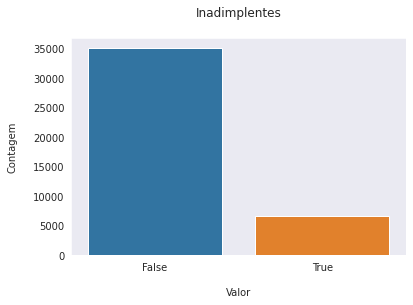

In [ ]:
# Proporção entre Inadimplentes no Dataset
fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes\n")
ax.set_xlabel("\nValor")
ax.set_ylabel("Contagem\n")
plt.show()

In [ ]:
print("Proporção entre Inadimplentes no dataset:")
print(df['target_default'].value_counts() / df.shape[0])
print("\nProporção de valor ausente no dataset:")
print((df['target_default'].isnull().sum() / df.shape[0]))

Proporção entre Inadimplentes no dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64

Proporção de valor ausente no dataset:
0.07242222222222222


Ou seja, temos 78% da variável target como `False`, 15% como `True`e 7% como `ausente`, devendo ser excluído da modelagem.

## Preparação dos Dados

Com as informações que obtivemos da etapa anterior, vamos prosseguir com a limpeza e preparação dos dados.

In [5]:
df_clean = df.copy()

# substituir inf por nan em reported_income 
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf,
                                                                  np.nan)

# descartar as colunas ids, target_fraud, external_data_provider_credit_checks_last_2_year e channel
df_clean.drop(labels=['ids', 'target_fraud', 'external_data_provider_credit_checks_last_2_year', 'channel'], axis=1, inplace=True)

#  substituir -999 em external_data_provider_email_seen_before por NaN
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0, 'external_data_provider_email_seen_before'] = np.nan

# eliminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel', 'profile_phone_number', 'shipping_state']
df_clean.drop(labels=drop_var, axis=1, inplace=True)

# elminar as entradas onde target_default é NaN (dados ausentes)
df_clean.dropna(subset=['target_default'], inplace=True)

Apesar de não haver maiores informações sobre as *features*, podemos assumir como premissa que muitos valores são nulos devido a dois fatores:

1. Há alguns itens que não são obrigatórios durante a etapa de preenchimento dos formulários, como a informação sobre o perfil do cliente no Facebook; e
2. Não existe observação alguma referente à algumas colunas, como é caso de `'last_amount_borrowed', 'last_borrowed_in_months' e 'n_issues'`.

De maneira geral, para as variáveis que se enquadram no segundo caso, os valores `NaN` serão substituídos por zero, pois no entendimento das variáveis indica que não houve empréstimo ou problema relatado. Para as demais variáveis numéricas, será adotado o valor da mediana, e para as categóricas o valor mais frequente.

In [6]:
from sklearn.impute import SimpleImputer

num_df = df_clean.select_dtypes(exclude='object').columns
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])

Podemos agora verificar que as variáveis escolhidas não possuem mais os valores nulos iniciais.

In [ ]:
# verificar a quantidade de dados nulos
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

Para melhorar o desempenho do modelo, irei normalizar as variáveis numéricas usando `StandardScaler`.

In [7]:
# criando uma cópia do df_clean (já executadas todas as limpezas e substituições anteriores)
scaled_df = df_clean.copy()

# normalizar as colunas numéricas
num_cols = scaled_df.drop('target_default', axis=1).select_dtypes(exclude='object').columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)

Continuando com a preparação dos dados, irei realizar o Label Encoding para possibilitar que as variáveis categóricas possam ser codificadas em forma de *labels* e alimentar o modelo de *Machine Learning*.

In [8]:
# criando uma cópia do df
encoded_df = scaled_df.copy()

# extrair as colunas categóricas
cat_cols = encoded_df.select_dtypes('object').columns

# codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)

In [ ]:
# banco de dados antes de normalizar, tendo aplicando somente as limpezas de dados ausentes e exclusão de algumas variáveis
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,state,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,N5/CE7lSkAfB04hVFFwllw==,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0.0,51.0,645.0,57849.0
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0.0,17.0,243.0,4902.0
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,False,Ygq6MsM98oC8yceExr69Ig==,n+xK9CfX0bCn77lClTWviw==,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1.0,9.0,65.0,163679.0
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,n+xK9CfX0bCn77lClTWviw==,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1.0,38.0,815.0,1086.0
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,n+xK9CfX0bCn77lClTWviw==,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1.0,46.0,320.0,198618.0


In [ ]:
# banco de dados transformado: normalização das variáveis numéricas e recodificação das variáveis categóricas
encoded_df.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_encoded,score_2_encoded,state_encoded,real_state_encoded
0,False,0.032154,0.563484,-0.832617,0.848870,1.039282,2.627224,1.11413,-1.031599,-0.116075,1.412589,-0.094349,-0.278592,-0.057693,1.604337,1.577495,1.341208,0.444809,-1.427247,1.322812,0.501783,-0.040691,0,10,44,1
1,False,0.213805,-0.924750,1.538588,-0.789902,-0.536149,-0.577743,-0.68792,0.283752,0.553756,-0.707920,1.191063,-0.278592,-0.057693,0.732520,0.937596,0.671463,-0.452701,-1.427247,-0.635622,-0.894101,-0.040691,3,16,47,1
2,True,0.122980,0.006361,-0.512003,1.294382,-0.043827,0.345051,1.11413,-0.196782,-0.115893,-0.707920,-0.094349,-0.278592,-0.057693,-0.139296,-1.302049,-1.652141,0.444809,0.700650,-1.096430,-1.512178,-0.040691,3,9,32,3
3,False,1.485366,0.500243,1.694857,-0.500560,0.251567,-0.577743,-0.68792,0.775941,-0.043057,-0.707920,-0.094349,3.365634,-0.057693,1.822291,1.737469,1.081511,1.342319,0.700650,0.573999,1.092082,-0.040691,0,21,23,3
4,False,1.394540,-0.481355,0.114978,1.816579,-1.126935,-0.577743,-0.68792,-0.196782,-0.211806,1.412589,-0.094349,-0.278592,-0.057693,0.078658,-1.302049,-0.052955,0.444809,0.700650,1.034807,-0.626730,-0.040691,2,1,47,3


Após conferência acima para entendimento do que foi feito antes e depois de normalizar e recodifiar, irei separar a variável alvo das demais e dividir o *dataset* entre dados de treino e teste com a função `train_test_split`. Aqui já começamos a preparar o banco de dados para aplicar na modelagem.

In [9]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']

# dividir o dataset entre treino e teste, sendo 30% utilizado para fazermos o teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
# confere divisão das bases Total, Train e Test

print("Total Base X: ",encoded_df.shape[0])
print("Base X Train: ", X_train.shape[0])
print("Base X Teste: ", X_test.shape[0])

Total Base X:  41741
Base X Train:  29218
Base X Teste:  12523


## Construção do Modelo

Após separarmos os dados entre dados de teste e treino, precisamos:

* Criar uma baseline a ser batida. Idealmente, usaríamos os resultados da solução atual empregada pela empresa, ou até uma métrica que não utilize *Machine Learning*. Como não estamos inseridos nesse cotexto, utilizaremos um modelo arbitrário, não parametrizado, como baseline.
* Definir a melhor métrica para avaliar nosso modelo.
* Comparar modelos diferentes levando a métrica alvo e o baseline como comparação.
* Tunar os hiperparâmetros em um conjunto de validação.
* Rodar o modelo em nossos dados de teste.


Arbitrariamente, escolhi o `RandomForestClassifier` para a construção do baseline. Não foi realizada uma análise mais aprofundada sobre as variáveis e nem um *tunning* de parâmetros. Aqui, poderia ter escolhido qualquer modelo para ser nosso baseline, ou seja, nosso ponto de partida para comparar as melhorias no modelo com os hiperparâmetros.

### Métricas e Modelos

Para decidirmos que métrica usar, precisamos analisar algumas de nossas opções.

* Caso optemos pela `Acurácia`, precisamos estar cientes que esse pode não ser o método ideal, mas para uma análise inicial do problema, pode nos ajudar a criar uma solução generalista.

* Caso optemos por otimizar o modelo a partir do `Recall`, estamos priorizando que não haja Falsos Negativos. Ou seja, é preferível negar um cliente que não traria prejuízo à empresa, do que aceitar um que traga. Essa é a forma que são tratados, por exemplo, fraudes em cartão de crédito, modelos médicos, etc.

* Caso optemos por otimizar a partir do `Precision`, essencialmente, estamos dizendo não queremos ter Falsos Negativos, se tiver Falso Positivo não é um problema. Ou seja, é preferível aceitar clientes que possam trazer prejuízo, que possa trazer default, do que não aceitar clientes que não trarão. Essa é a forma que são tratados, por exemplo, modelos para spam de e-mails.

Aqui, vamos utilizar a `Acurácia`, no intuito de realizar uma análise generalista, fazendo um *tunning* nos parâmetros até se chegar ao melhor modelo.

O que vai definir a melhor métrica é a estratégia de negócio da empresa, e seus valores. Também por isso, vamos utilizar essa métrica mais "genérica".

In [11]:
# construindo função de avaliação do baseline
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independentes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy')

    if quite == False:
        print("Acurácia: {:.4f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

In [ ]:
# criar modelo baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Acurácia: 0.8381 (+/- 0.00)


Apesar de estarmos lidando com dados desbalanceados e um modelo que não recebeu nenhum tuning de hiperparâmetros, fizemos apenas ajustes na base de dados, nosso modelo baseline é bastante competente, possui uma acurária relativamente alta - ~83%.

Com acurácia na casa de 83%, vamos ver o que podemos fazer para bater essa baseline.

### Modelos

Para tentar bater esse baseline, vamos testar diferentes modelos:

* Random Forest Classifier (Baseline)
* Decision Tree Classifier
* SGD Classifier
* SVC
* Logistic Regression
* XGB Classifier
* LGBM Classifier

In [ ]:
# instanciando os modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
acc = []

# avaliando o desempenho: para cada modelo instanciado, calcular a acurária
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    acc.append(val_model(X_train, y_train, clf, quite=True))

In [ ]:
pd.DataFrame(data=acc, index=model, columns=['ACC'])

,ACC
RandomForestClassifier,0.838011
DecisionTreeClassifier,0.739236
SGDClassifier,0.836744
SVC,0.837292
LogisticRegression,0.837087
XGBClassifier,0.838764
LGBMClassifier,0.838422


Ao realizar os testes com diferentes modelos, podemos ver que o `XGBClassifier`retornou os melhores resultados.

A margem foi pequena, o que suegere que, dada a devida parametrização, qualquer modelo dessa lista poderia ser tão eficiente ou até mais eficiente do que o `XGBClassifier`, mas devido ao seu resultado inicial, iremos seguir a partir dele.

Além de pesquisas externas, ver o que o pessoal que obtém bons resultados com esse modelo mexe em relação a parâmetros, e a própria documentação do modelo, podemos utilizar o método `get_params` para visualizar que parâmetros podem ser tunados para obtermos os melhores resultados.

Para mais referência em relação ao tunning de hiperparâmetros do XGBClassifier, veja esse [link](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e).

In [ ]:
# verificando os parâmetros
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# instanciando o modelo, com semente para mantermos sempre o mesmo resultado
xgb = XGBClassifier(random_state=42)

# definindo os parâmetros a serem testados
param_grid = { 
  'learning_rate': [0.001, 0.01, 0.1],  
  'gamma':[0, 1, 5],
  'subsample':[0.5, 1.5, 3.5],
  'max_depth': [1, 3, 5],
  'n_estimators': [100, 500, 1000],
  'colsample_bytree': [0.1, 0.5, 1]
 }
 

# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {:.4f} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8395 para {'colsample_bytree': 0.1, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.5}


In [12]:
# instanciando o modelo final com os melhores ajustes encontrados acima e treinando o mesmo
ml_model = XGBClassifier(learning_rate=0.1, max_depth=1, gamma=5,
                         n_estimators= 1000, min_child_weight=1, 
                         subsample = 0.5, colsample_bytree = 0.1,
                         random_state=42)

ml_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [13]:
# previsões e probabilidades em cima do dataset de teste
y_pred = ml_model.predict(X_test)
y_proba = ml_model.predict_proba(X_test)

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

Acurácia: 0.8476



In [ ]:
# confere previsões
pd.DataFrame(y_pred).head(15)

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


In [ ]:
# confere probabilidades
pd.DataFrame(y_proba).head()

,0,1
0,0.917381,0.082619
1,0.868236,0.131764
2,0.897481,0.102519
3,0.884883,0.115117
4,0.950523,0.049477


Lembra-se que o *dataset* utilizado neste projeto é desbalanceado, o que pode gerar métricas que não representam a realidade da situação problemática do mundo real.

### Construção do modelo com Rebalanceamento por UnderSample

In [14]:
# verificando o volume de fraude 
encoded_df_b = encoded_df[encoded_df.target_default == 1].shape[0]

print("Total Base Target: ", encoded_df_b)

Total Base Target:  6661


Escolhi fazer o balanceamento por UnderSample em função do tamanho do banco de dados. Como podemos ver acima, teremos `6.661` observações para trabalhar com um balanceamento de 50%, o que é considerado um volume suficiente para a modelagem. Mesmo separando os dados em 70% para treino, continuaremos com um volume bom para a modelagem balanceada.

True     4754
False    4754
dtype: int64


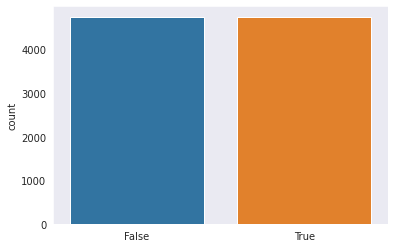

In [15]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

In [ ]:
pd.DataFrame(X_rus).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.304631,-0.731129,0.407958,0.505115,0.940817,-0.577743,-0.68792,-0.196782,-0.307540,-0.707920,-0.094349,-0.278592,-0.057693,1.386383,-1.302049,1.047340,0.444809,0.700650,1.438014,-0.366304,-0.040691,3.0,15.0,44.0,3.0
1,-0.785278,0.529466,0.091398,-0.051393,-0.930006,0.706188,1.11413,0.276435,0.367496,1.412589,-0.094349,-0.278592,-0.057693,-0.357250,0.137723,0.117899,-0.452701,0.700650,1.668418,0.189271,-0.040691,1.0,27.0,20.0,1.0
2,-0.331149,-0.574642,0.946766,-0.751149,-0.733077,-0.577743,-0.68792,-0.451270,-0.345780,-0.707920,1.905180,-0.278592,-0.057693,-0.139296,0.297698,0.042723,1.342319,-1.427247,0.689201,1.262227,-0.040691,3.0,6.0,5.0,1.0
3,-0.785278,-1.108619,1.561990,0.412915,0.546960,-0.577743,-0.68792,0.179222,0.515780,-0.707920,-0.094349,-0.278592,-0.057693,-0.139296,0.297698,0.247747,-1.350210,0.700650,1.553216,0.154548,-0.040691,3.0,15.0,12.0,1.0
4,2.575274,-1.545511,-0.324893,0.087745,0.350031,-0.577743,-0.68792,-0.154169,-0.460517,-0.707920,0.619769,3.365634,-0.057693,0.950475,1.097571,-1.248927,-1.350210,-1.427247,0.746802,0.064267,-0.040691,0.0,21.0,44.0,3.0


In [17]:
# ajustar a base balanceada para possuir os mesmos nomes das colunas da base de treino
X_rus_ = pd.DataFrame(X_rus, columns = X_train.columns)

X_rus_.head()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_encoded,score_2_encoded,state_encoded,real_state_encoded
0,0.304631,-0.731129,0.407958,0.505115,0.940817,-0.577743,-0.68792,-0.196782,-0.307540,-0.707920,-0.094349,-0.278592,-0.057693,1.386383,-1.302049,1.047340,0.444809,0.700650,1.438014,-0.366304,-0.040691,3.0,15.0,44.0,3.0
1,-0.785278,0.529466,0.091398,-0.051393,-0.930006,0.706188,1.11413,0.276435,0.367496,1.412589,-0.094349,-0.278592,-0.057693,-0.357250,0.137723,0.117899,-0.452701,0.700650,1.668418,0.189271,-0.040691,1.0,27.0,20.0,1.0
2,-0.331149,-0.574642,0.946766,-0.751149,-0.733077,-0.577743,-0.68792,-0.451270,-0.345780,-0.707920,1.905180,-0.278592,-0.057693,-0.139296,0.297698,0.042723,1.342319,-1.427247,0.689201,1.262227,-0.040691,3.0,6.0,5.0,1.0
3,-0.785278,-1.108619,1.561990,0.412915,0.546960,-0.577743,-0.68792,0.179222,0.515780,-0.707920,-0.094349,-0.278592,-0.057693,-0.139296,0.297698,0.247747,-1.350210,0.700650,1.553216,0.154548,-0.040691,3.0,15.0,12.0,1.0
4,2.575274,-1.545511,-0.324893,0.087745,0.350031,-0.577743,-0.68792,-0.154169,-0.460517,-0.707920,0.619769,3.365634,-0.057693,0.950475,1.097571,-1.248927,-1.350210,-1.427247,0.746802,0.064267,-0.040691,0.0,21.0,44.0,3.0


Não temos mais a discrepância dos dados desbalanceados.

Vamos ver se conseguimos indentificar alguma correlação mais forte com a base balanceada:

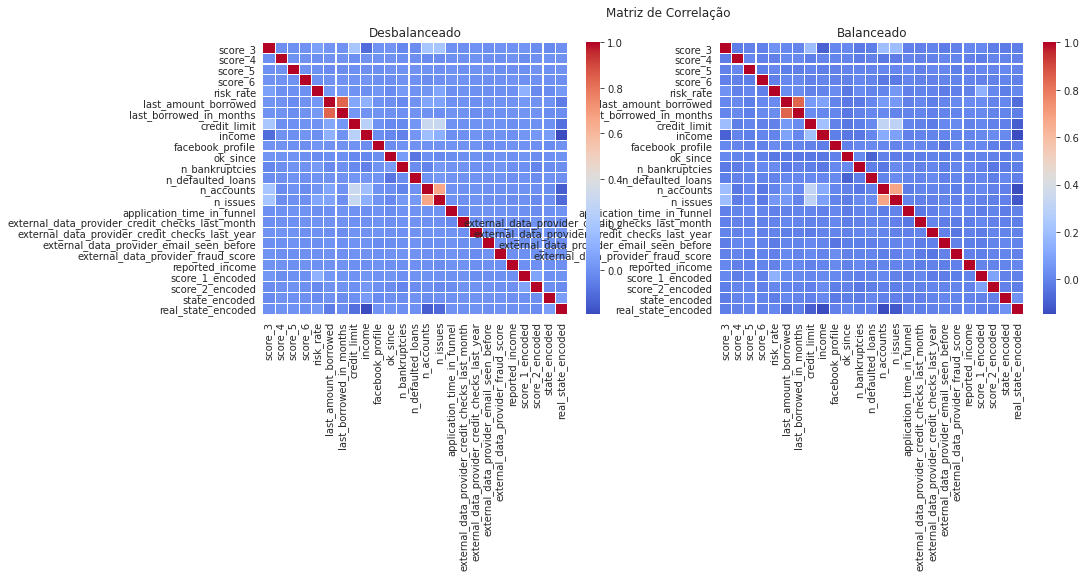

In [18]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = X_rus_.corr()

#corr_rus = pd.DataFrame(X_rus).corr()

# cria o espaço para aparecer o gráfico da correlação
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
fig.suptitle('Matriz de Correlação')

# cria gráfico de correlação da variável desbalanceada
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

# cria gráfico de correlação da variável balanceada
sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

Mesmo com os dados desbalanceados, ainda tínhamos um volume grande da classe target, então não conseguimos ver muito impacto na correlação entre as variáveis após o balanceamento da base.

In [19]:
# modelo com os dados balanceados
rf_b = RandomForestClassifier()
dt_b = DecisionTreeClassifier()
sgdc_b = SGDClassifier()
svc_b = SVC()
lr_b = LogisticRegression()
xgb_b = XGBClassifier()
lgbm_b = LGBMClassifier()

model_b = []
acc_b = []

# avaliando o desempenho: para cada modelo instanciado, calcular a acurária
for clf_b in (rf_b, dt_b, sgdc_b, svc_b, lr_b, xgb_b, lgbm_b):
    model_b.append(clf_b.__class__.__name__)
    acc_b.append(val_model(X_rus_, y_rus, clf_b, quite=False))

Acurácia: 0.6432 (+/- 0.01)
Acurácia: 0.5668 (+/- 0.00)
Acurácia: 0.6004 (+/- 0.01)
Acurácia: 0.6190 (+/- 0.00)
Acurácia: 0.6156 (+/- 0.00)
Acurácia: 0.6554 (+/- 0.01)
Acurácia: 0.6483 (+/- 0.00)


In [20]:
pd.DataFrame(data=acc_b, index=model_b, columns=['ACC Balanceado'])

,ACC Balanceado
RandomForestClassifier,0.643248
DecisionTreeClassifier,0.566786
SGDClassifier,0.600442
SVC,0.618953
LogisticRegression,0.615587
XGBClassifier,0.655447
LGBMClassifier,0.648296


Com os dados balanceados ficamos com uma **Acurácia de 65%**, quase **20 p.p.** abaixo do modelo desbalanceado. Ainda assim, o modelo `XGBClassifier` continua sendo o de melhor performance. Agora, na tentativa de melhorar esse desempenho, vamos partir para encontrar os melhores hiperparâmetros.

In [21]:
xgb_b.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [22]:
# instanciando o modelo, com semente para mantermos sempre o mesmo resultado
xgb_b = XGBClassifier(random_state=42)

# definindo os parâmetros a serem testados
param_grid = {
  'learning_rate': [0.001, 0.01, 0.1],  
  'gamma':[0, 1, 5],
  'subsample':[0.5, 1.5, 3.5],
  'max_depth': [1, 3, 5],
  'n_estimators': [100, 500, 1000],
  'colsample_bytree': [0.1, 0.5, 1]
 }

# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb_b, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_, y_rus)

# ver resultados
print("Melhor balanceado: {:.2f} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor balanceado: 0.66 para {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}


In [23]:
# instanciando o modelo e treinando o mesmo de acordo com os parâmetros obtidos acima como sendo `Melhor`
ml_model_b = XGBClassifier(learning_rate=0.01, max_depth=5, gamma=0,
                         n_estimators= 100, min_child_weight=1, 
                         subsample = 0.5, colsample_bytree = 0.5,
                         random_state=42)

ml_model_b.fit(X_rus_, y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [29]:
# previsões e probabilidades em cima do dataset de teste
y_pred_b  = ml_model_b.predict(X_test)
y_proba_b = ml_model_b.predict_proba(X_test)

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_b)))

Acurácia: 0.6720



Analisando os dados Desbalanceados e Balanceados, tivemos uma diferença na Acurária ao contrário do que imaginávamos:
* Baseline:0.8381
* Desbalanceados: 0.8476
* Balanceados: 0.6720 ( -17 p.p. em relação aos dados desbalanceados)

Em função disso, vamos olhar a Matriz de Confusão para ambos critérios (desbalanceado e balanceado):

### Medidas com Dados Desbalanceados

Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.8514    0.9938    0.9171     10616
        True     0.4962    0.0341    0.0638      1907

    accuracy                         0.8476     12523
   macro avg     0.6738    0.5139    0.4904     12523
weighted avg     0.7973    0.8476    0.7871     12523

Acurácia: 0.8476

AUC: 0.5139



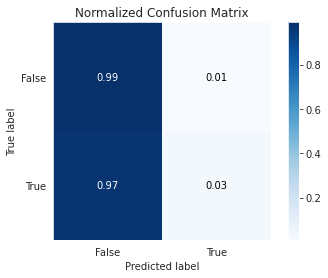

In [28]:
# plotar a matrix de confusão 
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

### Medidas com Dados Balanceados

Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.9097    0.6807    0.7787     10616
        True     0.2598    0.6240    0.3669      1907

    accuracy                         0.6720     12523
   macro avg     0.5848    0.6523    0.5728     12523
weighted avg     0.8108    0.6720    0.7160     12523

Acurácia: 0.6720

AUC: 0.6523



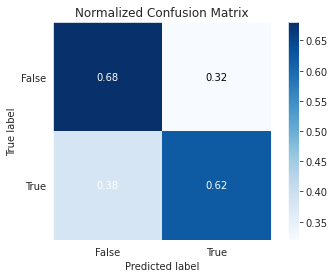

In [27]:
# plotar a matrix de confusão 
skplt.metrics.plot_confusion_matrix(y_test, y_pred_b, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_b, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_b)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_b)))

Como podemos ver, com os dados Balanceados tivemos um **True Positive de 62%** com os dados balanceados contra **3%** com os dados desbalanceados. Isso mostra a importância de termos feito o balanceamento mesmo tendo uma acurária alta com os dados desbalanceados, não retratando a natureza do problema.

## Conclusões

Como podemos ver, tivemos boas surpresas com os dados, com algumas situações interessantes:
Apesar de haver um certo desbalanceamento dos dados (~ 15%), esse valor é considerado baixo e, na teoria, não deveria termos impacto nas medidas de avaliação dos modelos. Ao efetuarmos a modelagem com os dados desbalanceados, tivemos uma boa acurácia, de 84%, o que normalmente nos faria achar que o modelo estava prevendo a real natureza do problema. Ao analisarmos a matriz de confusão, podemos perceber que essa conclusão seria errada, onde o modelo seria capade de prever os verdadeiros positivos em apenar 3% dos casos. Ao efetuarmos o rebalanceamento dos dados, tivemos uma queda grande na acurária (~17 p.p. de queda), mas um aumento absurdo na previsão dos verdadeiros positivos, indo para 62%.
Isso nos mostra da importância de se analisar o todo e, principalmente, se o resultado está de acordo com a natureza esperada do problema, entender essa parte do negócio é fundamental para a finalização da modelagem.

## Recomendações

Como recomendação de estudos, compartilho novamente o artigo sobre como tratar dados desbalanceados, altamente impactado nesse projeto: [Como lidar com dados desbalanceados](https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/).

Além disso, para métricas de avaliação de modelo temos vários critérios para utilizar, cada um de acordo com a disposição dos dados, do modelo criado e com o tipo de avaliação que se queira fazer. Abaixo temos algumas indicações que ajudam a esclarecer bem as dúvidas e a direcionar qual escolha podemos fazer:

- Para modelos de regressão: artigos
[1](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d), [2](https://www.dataquest.io/blog/understanding-regression-error-metrics/) e [3](https://towardsdatascience.com/art-of-choosing-metrics-in-supervised-models-part-1-f960ae46902e)

- Para modelos de classificação: artigos [1](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/), [2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) e [3](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772)

## Dúvidas, reclamações, sugestões etc

Estou iniciando esse projeto onde todo estudo que fizer irei compartilhar por aqui e gostaria muito de sugestões, reclamações, dúvidas etc.

Por favor, entre em contato direto comigo, abaixo deixo meus contatos para toda troca de informação.

- [Linkedin](www.linkedin.com/in/inaepmachado)

- [Email](inae.pmachado@gmail.com)

- [Github](https://github.com/inaepmachado)

Vlw!